Import

In [14]:
#import
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

**LoadData**

In [2]:
#
images = []
ages = []

for i in os.listdir('../input/utkface-new/crop_part1/')[0:8000]:
    split = i.split('_')
    ages.append(int(split[0]))

    images.append(Image.open('../input/utkface-new/crop_part1/' + i))

In [3]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')

df = pd.concat([images, ages], axis=1)
df

,Images,Ages
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,26
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,21
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,17
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,76
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,18
...,...,...
7995,<PIL.JpegImagePlugin.JpegImageFile image mode=...,3
7996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,28
7997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,10
7998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,8


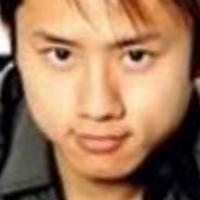

26


In [4]:
display(df['Images'][0])
print(df['Ages'][0])

**Visualising and Preparing Data**

In [8]:
x = []
y = []

for _, row in df.iterrows():
    # Resize ảnh
    img_resized = row['Images'].resize((200, 200), Image.Resampling.LANCZOS)
    # Chuyển sang array
    img_array = np.asarray(img_resized)
    x.append(img_array)

    # Lưu nhãn
    age = int(row['Ages'])
    y.append([age])

x = np.array(x)
y = np.array(y)

**Train test split**

In [9]:
y_age = df['Ages']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)

In [11]:
agemodel = Sequential()
agemodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(64, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(128, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Flatten())
agemodel.add(Dense(64, activation='relu'))
agemodel.add(Dropout(0.5))
agemodel.add(Dense(1, activation='relu'))

agemodel.compile(
    loss='mean_squared_error',
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=['mae']
)

**Training**

In [17]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_age, y_train_age, batch_size=32)

test2 = test_datagen.flow(
        x_test_age, y_test_age,
        batch_size=32)

history1 = agemodel.fit(train2, epochs=50, shuffle=True, validation_data=test2)

Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 234ms/step - loss: 733.2623 - mae: 21.8051 - val_loss: 455.1207 - val_mae: 17.8047
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 37s 229ms/step - loss: 501.9404 - mae: 18.4288 - val_loss: 427.1608 - val_mae: 17.0779
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 37s 230ms/step - loss: 484.2575 - mae: 18.1106 - val_loss: 374.7662 - val_mae: 15.8511
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 37s 228ms/step - loss: 411.7931 - mae: 16.5817 - val_loss: 322.6375 - val_mae: 14.5832
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 37s 230ms/step - loss: 390.0869 - mae: 15.8619 - val_loss: 302.8155 - val_mae: 13.9367
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 37s 230ms/step - loss: 366.8414 - mae: 15.3320 - val_loss: 318.7885 - val_mae: 13.9714
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 38s 233ms/step - loss: 372.6122 - mae: 15.4027 - val_loss: 299.1314 - val_mae: 13.5627
Epoch 8/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 37s 230ms/step - loss: 363.8006 - mae: 15.2780 - val_loss: 334.9873 - v

**Evaluating the Models**

In [19]:
agemodel.save('/kaggle/working/agemodel.h5')


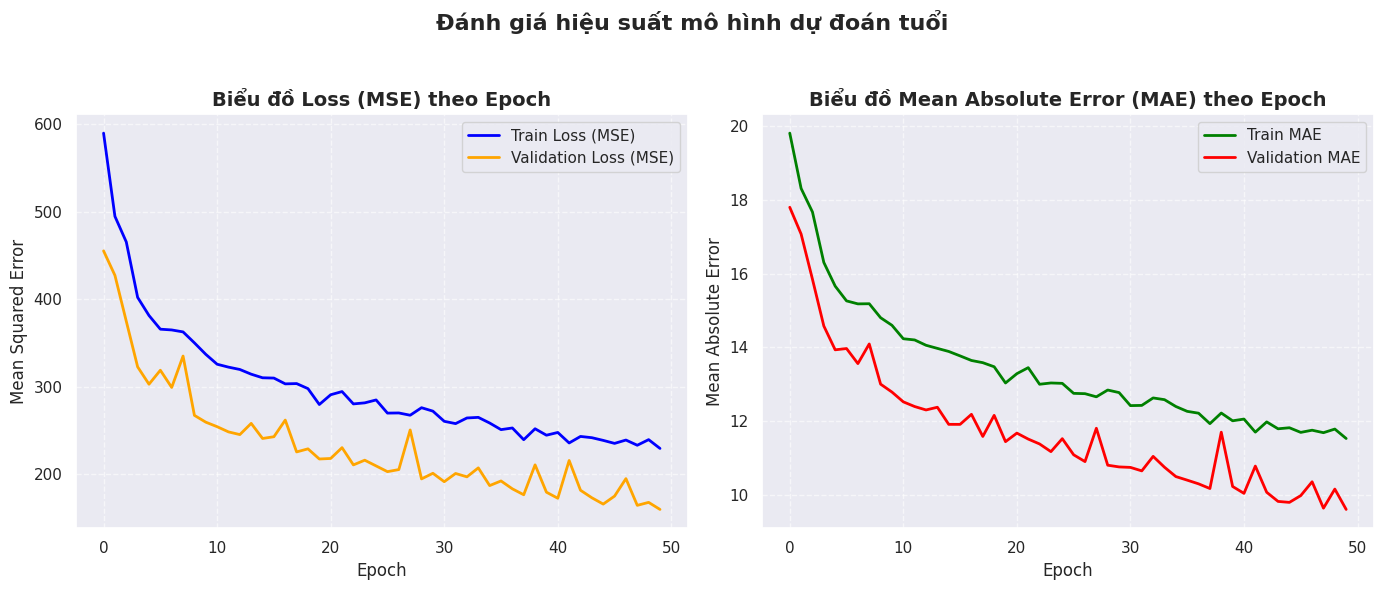

In [29]:
from matplotlib import pyplot as plt

plt.figure(figsize=(14,6))

# Biểu đồ Loss (Mean Squared Error)
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Train Loss (MSE)', color='blue', linewidth=2)
plt.plot(history1.history['val_loss'], label='Validation Loss (MSE)', color='orange', linewidth=2)
plt.title('Biểu đồ Loss (MSE) theo Epoch', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

# Biểu đồ MAE (Mean Absolute Error)
plt.subplot(1, 2, 2)
plt.plot(history1.history['mae'], label='Train MAE', color='green', linewidth=2)
plt.plot(history1.history['val_mae'], label='Validation MAE', color='red', linewidth=2)
plt.title('Biểu đồ Mean Absolute Error (MAE) theo Epoch', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Đánh giá hiệu suất mô hình dự đoán tuổi', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()